# Inferring a Station-Station Network Using NetworkX

In [1]:
!pip install networkx
!pip install folium
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 1.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
import os
import pandas as pd
import networkx as nx
import folium
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [4]:
"""Load previously collected EV charging station data"""
stations_path = os.path.join("/content/drive/MyDrive/ev_charging_analysis/", "charging_stations_san_francisco.csv")
stations_df = pd.read_csv(stations_path)
print(f"\nLoaded {len(stations_df)} charging stations")
print("\nFirst few stations:")
print(stations_df[['station_name', 'latitude', 'longitude', 'operator']].head())


Loaded 1000 charging stations

First few stations:
                     station_name   latitude   longitude operator
0  City of San Francisco - 49 SVN  37.774142 -122.418547  Unknown
1     HUDSON PACIFIC 1455 LOBBY 1  37.775745 -122.418191  Unknown
2   HUDSON PACIFIC 1455 STATION 1  37.774933 -122.417260  Unknown
3  HUDSON PACIFIC 1455 STATION 10  37.774846 -122.417113  Unknown
4      100 Van Ness - Garage - B1  37.776736 -122.418958  Unknown


# Create Network, Draw the network Graph and Basic Structure Analysis

In [5]:
import operator
from functools import reduce

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points in kilometers
    """
    R = 6371 # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [22]:
def create_weighted_edges(stations_df, max_distance=5.0, max_edges_per_node=5):
    """
    Create weighted edges between charging stations based on distance
    with a limit on the number of edges per node
    """
    edges_with_weights = []

    for i, station1 in stations_df.iterrows():
        station_edges = []

        for j, station2 in stations_df.iterrows():
            if i != j:
                distance = haversine_distance(
                    station1['latitude'], station1['longitude'],
                    station2['latitude'], station2['longitude']
                )

                if distance <= max_distance:
                    weight = 1 / (1 + distance)

                    weight *= np.sqrt(station1['num_points'] * station2['num_points'])

                    station_edges.append({
                        'destination': j,
                        'weight': weight,
                        'distance': distance
                    })

        station_edges.sort(key=lambda x: x['weight'], reverse=True)
        edges_with_weights.extend([
            {
                'source': i,
                'destination': edge['destination'],
                'weight': edge['weight'],
                'distance': edge['distance']
            }
            for edge in station_edges[:max_edges_per_node]
        ])

    return edges_with_weights

In [23]:
def create_subset_graph(edges_with_weights, thr=0.005, graphtype='Directed'):
    """
    Creates a graph from weighted edges, keeping only the top edges by weight

    Parameters:
        edges_with_weights: List of dictionaries containing edges and their weights
        thr: Threshold for edge inclusion (proportion of top edges to keep)
        graphtype: 'Directed' or 'UnDirected'

    Returns:
        NetworkX graph
    """
    if graphtype == 'Directed':
        g = nx.DiGraph()
    elif graphtype == 'UnDirected':
        g = nx.Graph()
    else:
        raise ValueError("graphtype must be either 'Directed' or 'UnDirected'")

    edges_with_weights_new = list(
        filter(
            lambda edg: edg['edge'][0] != edg['edge'][1],
            sorted(edges_with_weights, reverse=True, key=operator.itemgetter('weight'))
        )
    )

    num_edges_to_keep = int(len(edges_with_weights) * thr)
    edges_with_weights_new = edges_with_weights_new[:num_edges_to_keep]

    for edge_wt in edges_with_weights_new:
        g.add_edge(edge_wt['edge'][0], edge_wt['edge'][1], weight=edge_wt['weight'])

    return g

In [24]:
def plot_network(G, node_sizes=None, title=None):
    """
    Plot the network with customizable node sizes
    """
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    if node_sizes is None:
        node_sizes = [G.nodes[node].get('num_points', 1) * 50 for node in G.nodes()]

    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='blue')

    nx.draw_networkx_nodes(G, pos,
                            node_color='red',
                            node_size=node_sizes,
                            alpha=0.7)

    plt.title(title or 'EV Charging Network')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [25]:
def create_charging_network(stations_df, max_distance=5.0, max_edges_per_node=5):
    """
    Create complete charging station network
    """
    G = nx.DiGraph()

    for idx, row in stations_df.iterrows():
        G.add_node(idx,
                   pos=(row['longitude'], row['latitude']),
                   name=row['station_name'],
                   num_points=row['num_points'],
                   operator=row['operator'])

    edges_with_weights = create_weighted_edges(
        stations_df,
        max_distance=max_distance,
        max_edges_per_node=max_edges_per_node
    )

    for edge in edges_with_weights:
        G.add_edge(edge['source'], edge['destination'],
                   weight=edge['weight'],
                   distance=edge['distance'])

    return G

In [10]:
def analyze_network(G):
    """
    Analyze network properties
    """
    analysis = {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'density': nx.density(G),
        'clustering_coeff': nx.average_clustering(G),
        'strongly_connected_components': nx.number_strongly_connected_components(G),
        'weakly_connected_components': nx.number_weakly_connected_components(G)
    }
    return analysis

In [11]:
stations_path = "/content/drive/MyDrive/ev_charging_analysis/charging_stations_san_francisco.csv"
stations_df = pd.read_csv(stations_path)

# Create Network

In [12]:
# Create network
G = create_charging_network(
    stations_df,
    max_distance=5.0,  # Allow connections up to 5km
    max_edges_per_node=5  # Limit to 5 connections per station
)

# Network analysis

In [13]:

analysis = analyze_network(G)
print("\nNetwork Analysis:")
for metric, value in analysis.items():
    print(f"{metric}: {value}")


Network Analysis:
num_nodes: 1000
num_edges: 4981
avg_degree: 9.962
density: 0.004985985985985986
clustering_coeff: 0.5721432496075731
strongly_connected_components: 242
weakly_connected_components: 6


# Plot network

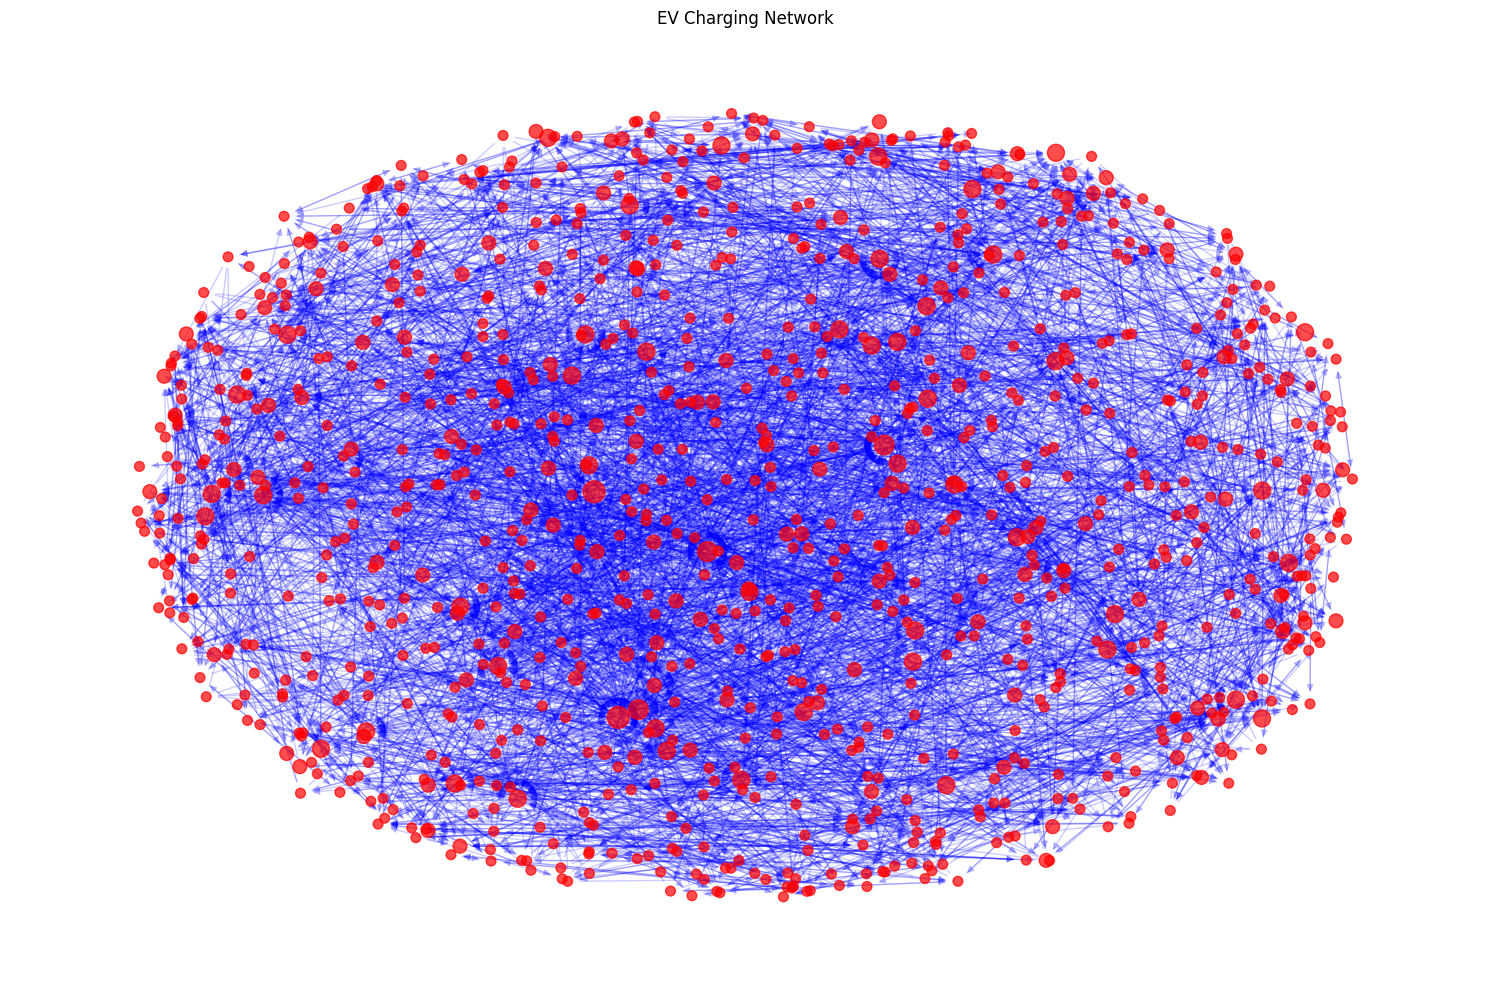

In [14]:
node_sizes = [G.nodes[node].get('num_points', 1) * 50 for node in G.nodes()]
plot_network(G, node_sizes=node_sizes, title='EV Charging Network')

# Strongly and Weakly connected components

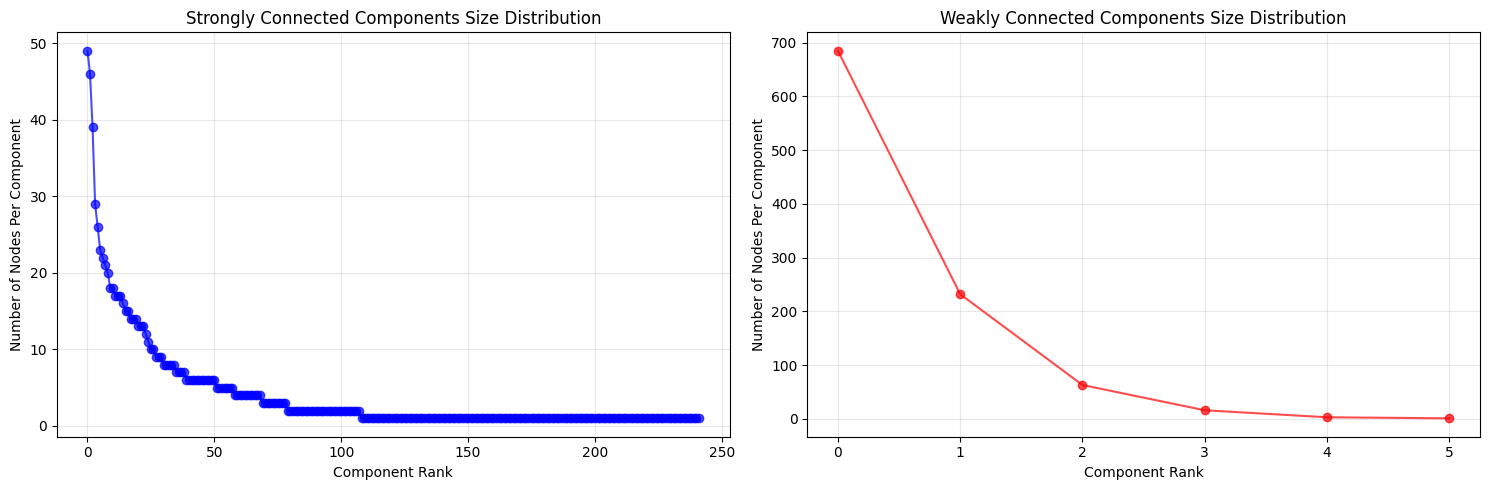

In [26]:

scc = list(nx.strongly_connected_components(G))
scc_sizes = sorted([len(c) for c in scc], reverse=True)

wcc = list(nx.weakly_connected_components(G))
wcc_sizes = sorted([len(c) for c in wcc], reverse=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(scc_sizes, marker='o', linestyle='-', color='blue', alpha=0.7)
ax1.set_title('Strongly Connected Components Size Distribution')
ax1.set_xlabel('Component Rank')
ax1.set_ylabel('Number of Nodes Per Component')
ax1.grid(True, alpha=0.3)

ax2.plot(wcc_sizes, marker='o', linestyle='-', color='red', alpha=0.7)
ax2.set_title('Weakly Connected Components Size Distribution')
ax2.set_xlabel('Component Rank')
ax2.set_ylabel('Number of Nodes Per Component')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
print("\nStrongly Connected Components Analysis:")
print(f"Number of SCCs: {len(scc)}")
print(f"Largest SCC size: {scc_sizes[0]} nodes")
scc_sizes_series = pd.Series(scc_sizes)
print("\nSCC Size Distribution:")
print(scc_sizes_series.value_counts().sort_index())

print("\nWeakly Connected Components Analysis:")
print(f"Number of WCCs: {len(wcc)}")
print(f"Largest WCC size: {wcc_sizes[0]} nodes")
wcc_sizes_series = pd.Series(wcc_sizes)
print("\nWCC Size Distribution:")
print(wcc_sizes_series.value_counts().sort_index())


Strongly Connected Components Analysis:
Number of SCCs: 242
Largest SCC size: 49 nodes

SCC Size Distribution:
1     134
2      29
3      10
4      11
5       7
6      12
7       4
8       5
9       3
10      2
11      1
12      1
13      3
14      3
15      2
16      1
17      3
18      2
20      1
21      1
22      1
23      1
26      1
29      1
39      1
46      1
49      1
Name: count, dtype: int64

Weakly Connected Components Analysis:
Number of WCCs: 6
Largest WCC size: 685 nodes

WCC Size Distribution:
1      1
3      1
16     1
63     1
232    1
685    1
Name: count, dtype: int64


# In Degree and Out Degree

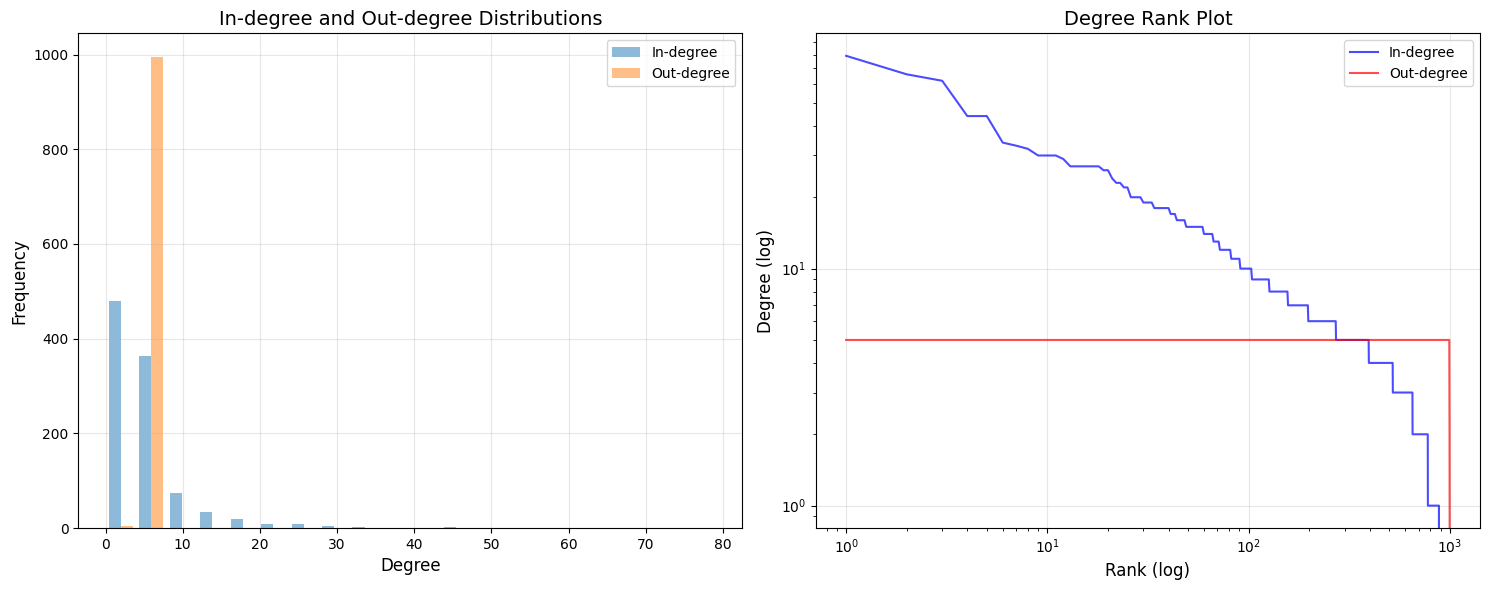

In [28]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

in_degrees_sorted = sorted(in_degrees.values(), reverse=True)
out_degrees_sorted = sorted(out_degrees.values(), reverse=True)

ranks = list(range(1, len(in_degrees_sorted) + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist([in_degrees_sorted, out_degrees_sorted],
          label=['In-degree', 'Out-degree'],
          bins=20, alpha=0.5)
ax1.set_xlabel('Degree', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('In-degree and Out-degree Distributions', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.loglog(ranks, in_degrees_sorted, 'b-', alpha=0.7, label='In-degree')
ax2.loglog(ranks, out_degrees_sorted, 'r-', alpha=0.7, label='Out-degree')
ax2.set_xlabel('Rank (log)', fontsize=12)
ax2.set_ylabel('Degree (log)', fontsize=12)
ax2.set_title('Degree Rank Plot', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:
print("\nDegree Statistics:")
print("\nIn-degree:")
print(f"Mean: {np.mean(list(in_degrees.values())):.2f}")
print(f"Max: {max(in_degrees.values())}")
print(f"Min: {min(in_degrees.values())}")

print("\nOut-degree:")
print(f"Mean: {np.mean(list(out_degrees.values())):.2f}")
print(f"Max: {max(out_degrees.values())}")
print(f"Min: {min(out_degrees.values())}")

correlation = np.corrcoef(list(in_degrees.values()), list(out_degrees.values()))[0,1]
print(f"\nCorrelation between in-degree and out-degree: {correlation:.3f}")


Degree Statistics:

In-degree:
Mean: 4.98
Max: 79
Min: 0

Out-degree:
Mean: 4.98
Max: 5
Min: 0

Correlation between in-degree and out-degree: 0.044


# Connected Components and Giant Connected Component

In [18]:
def graph_summary(G):
    summary_str = f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n"

    avg_degree = sum(dict(G.degree()).values())/G.number_of_nodes()
    summary_str += f"Average degree: {avg_degree:.2f}\n"
    return summary_str

In [19]:
und_g = G.to_undirected()
sub_graphs = (und_g.subgraph(c).copy() for c in nx.connected_components(und_g))
print('number of connected components: ' + str(len([k for k in sub_graphs])))

number of connected components: 6


In [20]:
sub_graphs = (und_g.subgraph(c).copy() for c in nx.connected_components(und_g))
sub_graphs = [k for k in sub_graphs]

In [21]:
Gc = max(sub_graphs, key=len)
Gc=nx.convert_node_labels_to_integers(Gc)
Gc.name='GCC'
print(graph_summary(Gc))

Graph with 685 nodes and 2511 edges
Average degree: 7.33



In [29]:
N, K = G.order(), G.size()
avg_deg = float(K) / N
print("Average degree: ", avg_deg)

Average degree:  4.981


In [30]:
print("Density: ", nx.density(G))

Density:  0.004985985985985986


# Degree Distribution

In [31]:
from collections import Counter
def calculate_degree_distribution(G):
    degrees = dict(G.degree())
    degree_distribution = Counter(degrees.values())
    return sorted(degree_distribution.items())

In [32]:
degree_distribution = calculate_degree_distribution(G)
print("Degree Distribution\n")
print(degree_distribution)

Degree Distribution

[(0, 1), (2, 2), (4, 2), (5, 115), (6, 105), (7, 124), (8, 131), (9, 125), (10, 124), (11, 74), (12, 41), (13, 30), (14, 23), (15, 13), (16, 9), (17, 10), (18, 5), (19, 7), (20, 11), (21, 5), (22, 3), (23, 7), (24, 4), (25, 4), (27, 2), (28, 2), (29, 1), (31, 2), (32, 6), (34, 1), (35, 3), (37, 1), (38, 1), (39, 1), (49, 2), (67, 1), (71, 1), (84, 1)]


In [33]:
def visualize_degree_distribution(degree_distribution):
    degrees, counts = zip(*degree_distribution)
    plt.figure(figsize=(10, 6))
    plt.bar(degrees, counts, width=1.0, color='skyblue')
    plt.title('Degree Distribution of the Network')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.xlim(left=0, right=max(degrees)+1)
    plt.tight_layout()
    plt.show()

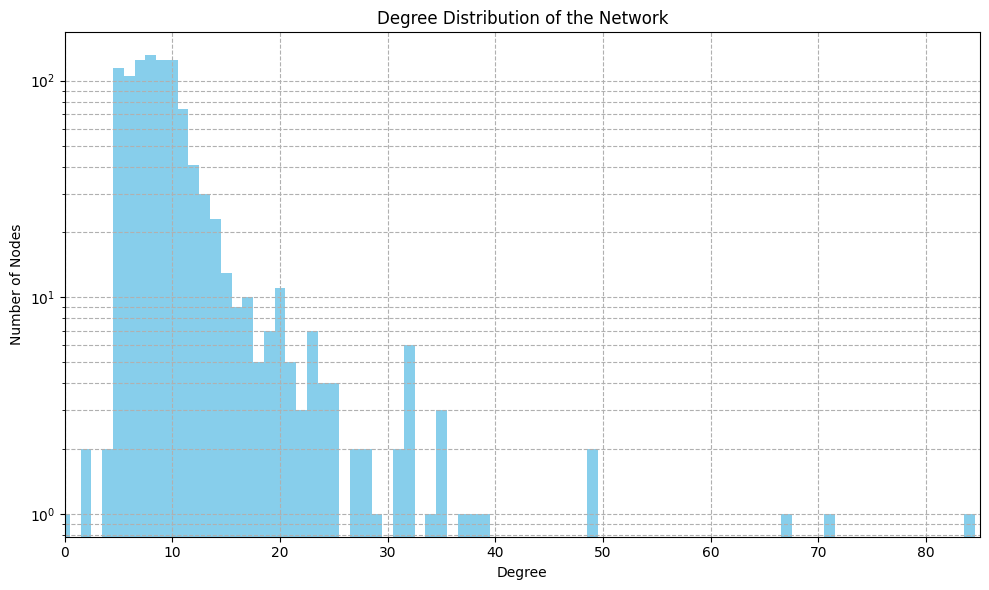

In [34]:
visualize_degree_distribution(degree_distribution)

# Degree Centrality

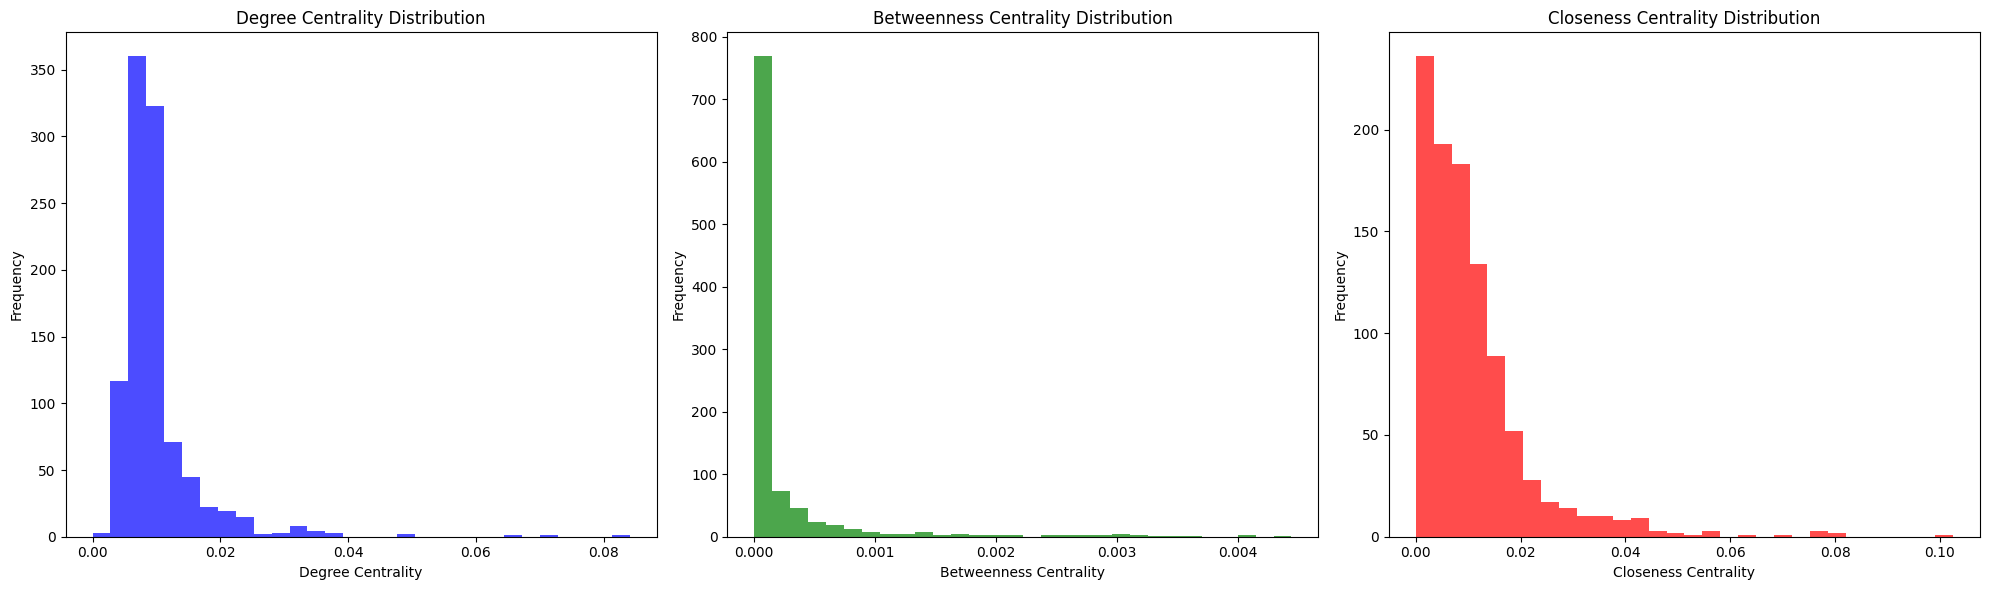

In [35]:
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)
closeness_cent = nx.closeness_centrality(G)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.hist(list(degree_cent.values()), bins=30, color='blue', alpha=0.7)
ax1.set_title('Degree Centrality Distribution')
ax1.set_xlabel('Degree Centrality')
ax1.set_ylabel('Frequency')

ax2.hist(list(betweenness_cent.values()), bins=30, color='green', alpha=0.7)
ax2.set_title('Betweenness Centrality Distribution')
ax2.set_xlabel('Betweenness Centrality')
ax2.set_ylabel('Frequency')

ax3.hist(list(closeness_cent.values()), bins=30, color='red', alpha=0.7)
ax3.set_title('Closeness Centrality Distribution')
ax3.set_xlabel('Closeness Centrality')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [37]:
print("\nCentrality Metrics Summary:")
print("\nDegree Centrality:")
print(f"Mean: {np.mean(list(degree_cent.values())):.4f}")
print(f"Max: {max(degree_cent.values()):.4f}")
print(f"Min: {min(degree_cent.values()):.4f}")

print("\nBetweenness Centrality:")
print(f"Mean: {np.mean(list(betweenness_cent.values())):.4f}")
print(f"Max: {max(betweenness_cent.values()):.4f}")
print(f"Min: {min(betweenness_cent.values()):.4f}")

print("\nCloseness Centrality:")
print(f"Mean: {np.mean(list(closeness_cent.values())):.4f}")
print(f"Max: {max(closeness_cent.values()):.4f}")
print(f"Min: {min(closeness_cent.values()):.4f}")


Centrality Metrics Summary:

Degree Centrality:
Mean: 0.0100
Max: 0.0841
Min: 0.0000

Betweenness Centrality:
Mean: 0.0002
Max: 0.0044
Min: 0.0000

Closeness Centrality:
Mean: 0.0106
Max: 0.1025
Min: 0.0000


# Clustering Coefficient

In [38]:
print("Average Clustering Coefficient", nx.average_clustering(G))

Average Clustering Coefficient 0.5721432496075731


(0.5721432496075736, 0.19710936043660918)

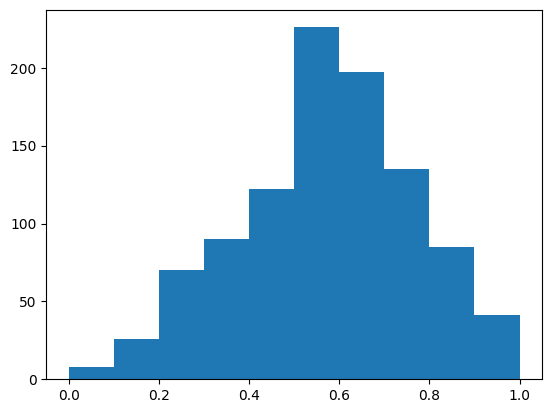

In [39]:
c = nx.cluster.clustering(G)
plt.hist(c.values())
np.mean(list(c.values())), np.std(list(c.values()))

Text(0.5, 0, 'Number of Nodes')

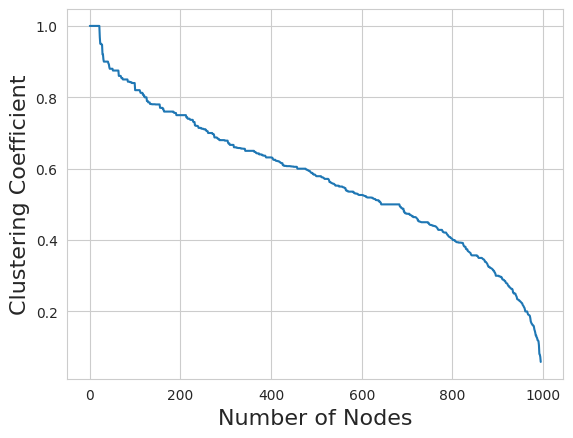

In [41]:
sns.set_style('whitegrid')
clustering_coefficients=list(filter
    (lambda y: y[1]>0,sorted(
        nx.clustering(G).items(),key=lambda x: x[1],reverse=True)))
plt.figure()
plt.plot(list(map(lambda x: x[1],clustering_coefficients)))
plt.ylabel("Clustering Coefficient",fontsize=16)
plt.xlabel("Number of Nodes",fontsize=16)

# PageRank and HITS

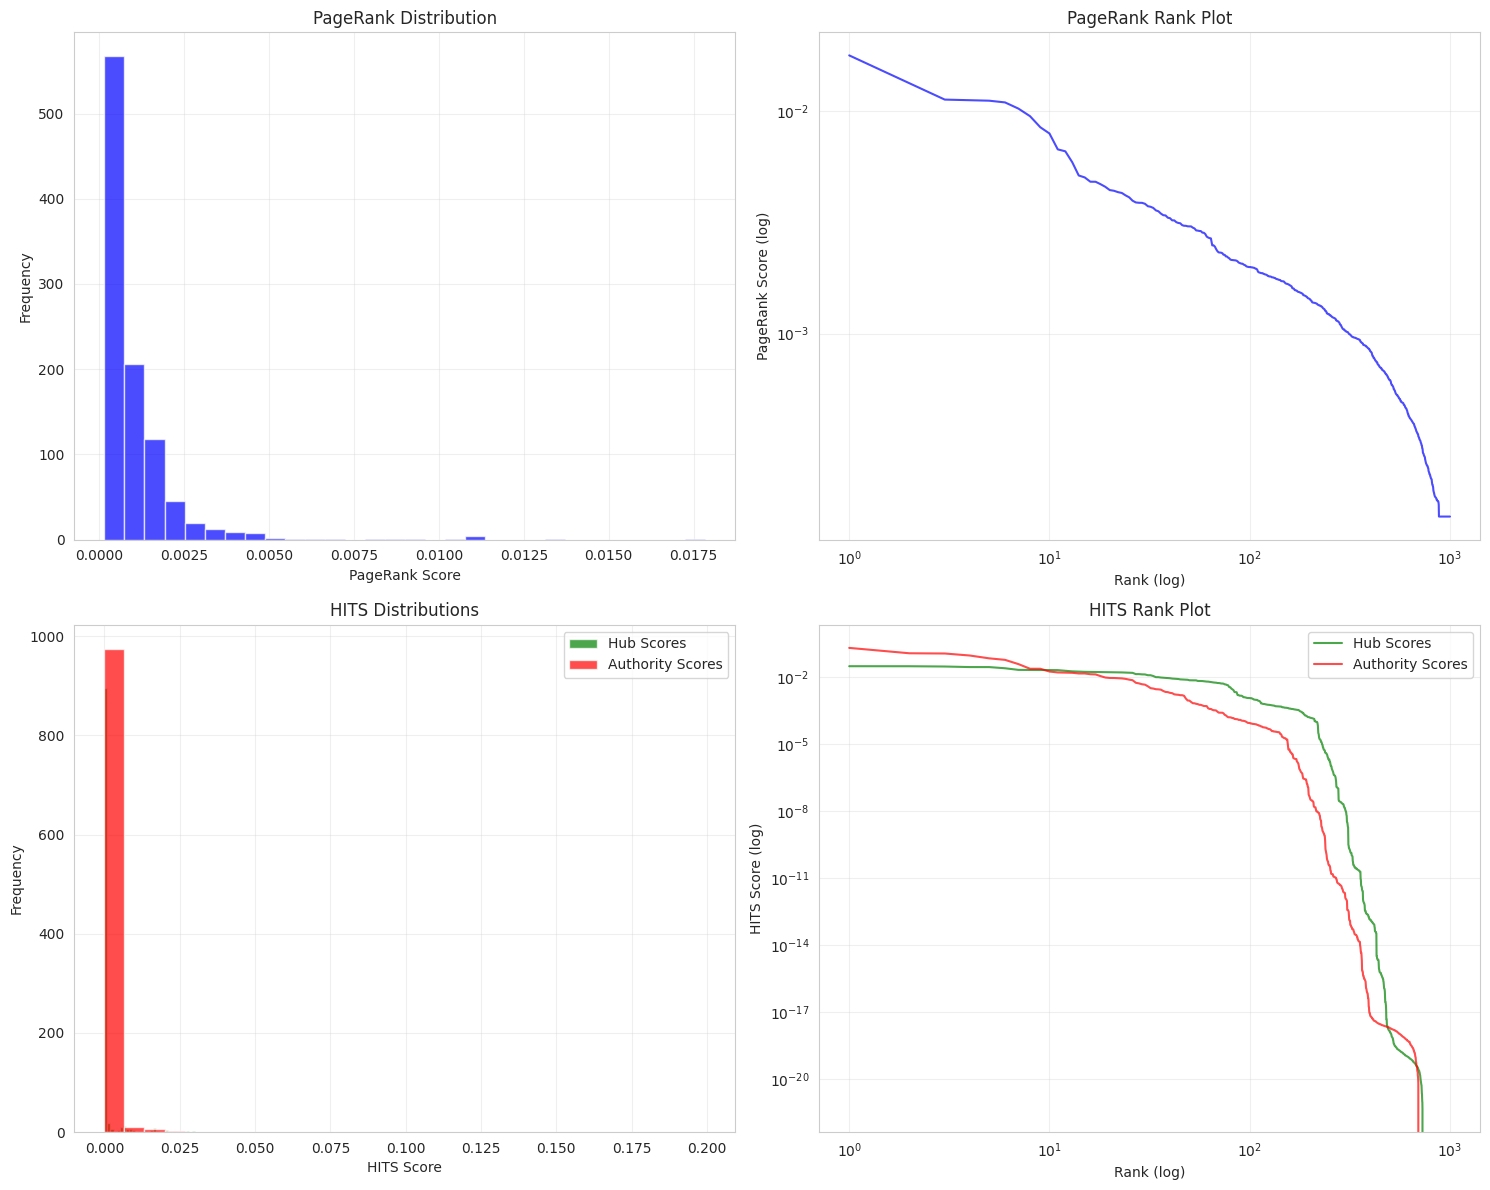

In [45]:
pagerank = nx.pagerank(G)

hits_hubs, hits_authorities = nx.hits(G)

scores_df = pd.DataFrame({
    'PageRank': pd.Series(pagerank),
    'Hub Score': pd.Series(hits_hubs),
    'Authority Score': pd.Series(hits_authorities)
})

pagerank_sorted = sorted(pagerank.values(), reverse=True)
hubs_sorted = sorted(hits_hubs.values(), reverse=True)
auth_sorted = sorted(hits_authorities.values(), reverse=True)

ranks = list(range(1, len(pagerank) + 1))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax1.hist(list(pagerank.values()), bins=30, alpha=0.7, color='blue')
ax1.set_title('PageRank Distribution')
ax1.set_xlabel('PageRank Score')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

ax2.loglog(ranks, pagerank_sorted, 'b-', alpha=0.7, label='PageRank')
ax2.set_title('PageRank Rank Plot')
ax2.set_xlabel('Rank (log)')
ax2.set_ylabel('PageRank Score (log)')
ax2.grid(True, alpha=0.3)

ax3.hist(list(hits_hubs.values()), bins=30, alpha=0.7, label='Hub Scores', color='green')
ax3.hist(list(hits_authorities.values()), bins=30, alpha=0.7, label='Authority Scores', color='red')
ax3.set_title('HITS Distributions')
ax3.set_xlabel('HITS Score')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.loglog(ranks, hubs_sorted, 'g-', alpha=0.7, label='Hub Scores')
ax4.loglog(ranks, auth_sorted, 'r-', alpha=0.7, label='Authority Scores')
ax4.set_title('HITS Rank Plot')
ax4.set_xlabel('Rank (log)')
ax4.set_ylabel('HITS Score (log)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
print("\nTop 10 Stations by PageRank:")
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
for idx, (node, score) in enumerate(top_pagerank, 1):
    station_name = stations_df.iloc[node]['station_name']
    operator = stations_df.iloc[node]['operator']
    print(f"{idx}. {station_name} ({operator}): {score:.4f}")

print("\nTop 10 Hub Stations:")
top_hubs = sorted(hits_hubs.items(), key=lambda x: x[1], reverse=True)[:10]
for idx, (node, score) in enumerate(top_hubs, 1):
    station_name = stations_df.iloc[node]['station_name']
    operator = stations_df.iloc[node]['operator']
    print(f"{idx}. {station_name} ({operator}): {score:.4f}")

print("\nTop 10 Authority Stations:")
top_auth = sorted(hits_authorities.items(), key=lambda x: x[1], reverse=True)[:10]
for idx, (node, score) in enumerate(top_auth, 1):
    station_name = stations_df.iloc[node]['station_name']
    operator = stations_df.iloc[node]['operator']
    print(f"{idx}. {station_name} ({operator}): {score:.4f}")


Top 10 Stations by PageRank:
1. Whole Foods San Francisco -Trinity Place (Unknown): 0.0178
2. ALCO STATIONS (Unknown): 0.0134
3. UC Hastings Larkin Garage (Unknown): 0.0113
4. EVgo 350 Pacific Hub (Unknown): 0.0112
5. San Francisco City Hall (Unknown): 0.0112
6. CITY OF OAKLAND (Unknown): 0.0110
7. Soma Grand (Unknown): 0.0103
8. Jack London Square (Unknown): 0.0095
9. Dr Carlton B Goodlett Pl (Unknown): 0.0085
10. Mark Hopkins InterContinental Hotel (Unknown): 0.0079

Top 10 Hub Stations:
1. San Francisco City Hall (Unknown): 0.0301
2. Soma Grand (Unknown): 0.0301
3. UC Hastings Larkin Garage (Unknown): 0.0292
4. Dr Carlton B Goodlett Pl (Unknown): 0.0276
5. Whole Foods San Francisco -Trinity Place (Unknown): 0.0275
6. HUDSON PACIFIC 1455 LOBBY 1 (Unknown): 0.0244
7. AMC Parking Lot Geary Blvd (Unknown): 0.0206
8. Dolby Laboratories (Unknown): 0.0204
9. ACE Parking (Unknown): 0.0204
10. CCSF SFMTA (Unknown): 0.0203

Top 10 Authority Stations:
1. Whole Foods San Francisco -Trinity Pla

# Community Dectection and Analysis

In [48]:
!pip install python-louvain

In [53]:
isolated = list(nx.isolates(und_g))  # Get isolated nodes
und_g.remove_nodes_from(isolated)    # Remove them from the graph


Detected 32 communities

Community sizes:
Community 3: 105 stations
Community 13: 101 stations
Community 0: 63 stations
Community 1: 62 stations
Community 12: 56 stations
Community 17: 49 stations
Community 27: 47 stations
Community 10: 40 stations
Community 25: 39 stations
Community 28: 39 stations


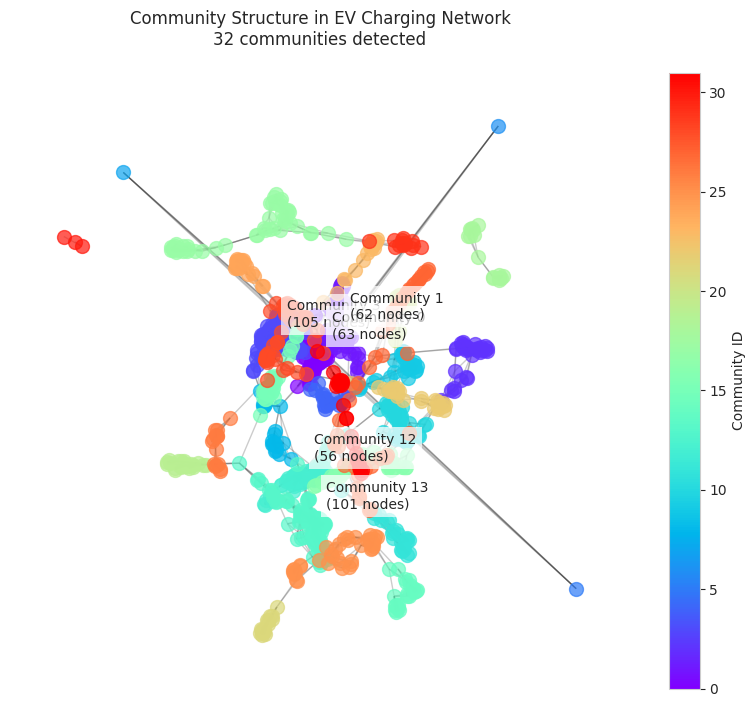

In [57]:
import community.community_louvain as community_louvain
from collections import defaultdict
import matplotlib.colors as mcolors

communities = community_louvain.best_partition(und_g)

num_communities = len(set(communities.values()))
print(f"\nDetected {num_communities} communities")

community_sizes = defaultdict(int)
for node, community_id in communities.items():
    community_sizes[community_id] += 1

sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
print("\nCommunity sizes:")
for comm_id, size in sorted_communities[:10]:
    print(f"Community {comm_id}: {size} stations")

fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.rainbow(np.linspace(0, 1, num_communities))

pos = nx.spring_layout(und_g)

for community_id in set(communities.values()):
    nodes_in_comm = [node for node in und_g.nodes()
                    if communities[node] == community_id]

    nx.draw_networkx_nodes(und_g, pos,
                          nodelist=nodes_in_comm,
                          node_color=[colors[community_id]],
                          node_size=100,
                          alpha=0.7)

nx.draw_networkx_edges(und_g, pos, alpha=0.2)

for comm_id, size in sorted_communities[:5]:
    nodes_in_comm = [node for node, c_id in communities.items() if c_id == comm_id]
    central_node = min(nodes_in_comm, key=lambda n: sum(nx.shortest_path_length(und_g, n, target)
                                                      for target in nodes_in_comm))

    plt.annotate(f'Community {comm_id}\n({size} nodes)',
                xy=pos[central_node],
                xytext=(10, 10),
                textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title(f"Community Structure in EV Charging Network\n{num_communities} communities detected",
          pad=20)
plt.axis('off')

sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow,
                          norm=plt.Normalize(vmin=0, vmax=num_communities-1))
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Community ID')

plt.show()

In [58]:
print("\nCommunity Analysis:")
for comm_id, size in sorted_communities[:5]:
  nodes_in_comm = [node for node, c_id in communities.items() if c_id == comm_id]
  subgraph = G.subgraph(nodes_in_comm)

  stations_in_comm = stations_df.iloc[nodes_in_comm]

  print(f"\nCommunity {comm_id} ({size} stations):")
  print(f"Average degree: {np.mean([d for n, d in subgraph.degree()]):.2f}")
  print(f"Density: {nx.density(subgraph):.3f}")


Community Analysis:

Community 3 (105 stations):
Average degree: 9.52
Density: 0.046

Community 13 (101 stations):
Average degree: 9.92
Density: 0.050

Community 0 (63 stations):
Average degree: 9.43
Density: 0.076

Community 1 (62 stations):
Average degree: 9.19
Density: 0.075

Community 12 (56 stations):
Average degree: 9.71
Density: 0.088


# Degree Distribution vs Density

<ipython-input-69-3ab8ee26d4a2>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.Series(np.array(node_degrees).T[1], name='Degree Distribution'), ax=ax)


<Axes: xlabel='Degree Distribution', ylabel='Density'>

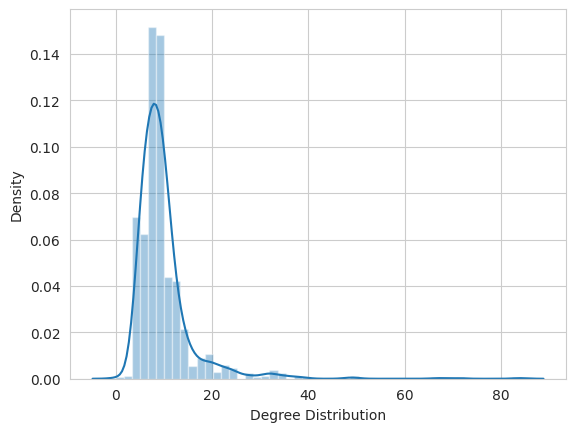

In [69]:
node_degrees = [item for item in dict(G.degree()).items()]
fig, ax = plt.subplots()
sns.distplot(pd.Series(np.array(node_degrees).T[1], name='Degree Distribution'), ax=ax)

# Small World Analysis

In [70]:
largest_component = max(nx.connected_components(und_g), key=len)
G_largest = und_g.subgraph(largest_component).copy()
print("Largest connected component has", len(G_largest), "nodes and", G_largest.number_of_edges(), "edges.")

Largest connected component has 685 nodes and 2511 edges.


In [71]:
from networkx.algorithms.smallworld import random_reference
import math

original_avg_clustering = nx.average_clustering(G_largest)
original_avg_shortest_path = nx.average_shortest_path_length(G_largest)
print("Original Graph:")
print("Average Clustering Coefficient:", original_avg_clustering)
print("Average Shortest Path Length:", original_avg_shortest_path)
print("ln(number of nodes):", math.log(len(G_largest.nodes)))

random_graph = random_reference(G_largest, niter=3, connectivity=False)

largest_cc = max(nx.connected_components(random_graph), key=len)
largest_cc_graph = random_graph.subgraph(largest_cc)

random_avg_clustering = nx.average_clustering(largest_cc_graph)
random_avg_shortest_path = nx.average_shortest_path_length(largest_cc_graph)
print("\nRandom Graph:")
print("Average Clustering Coefficient:", random_avg_clustering)
print("Average Shortest Path Length:", random_avg_shortest_path)
print("ln(number of nodes):", math.log(len(largest_cc_graph.nodes)))

Original Graph:
Average Clustering Coefficient: 0.6955337864823151
Average Shortest Path Length: 12.343424254065821
ln(number of nodes): 6.529418838262226

Random Graph:
Average Clustering Coefficient: 0.0216787414548298
Average Shortest Path Length: 3.280390148119691
ln(number of nodes): 6.529418838262226


# Erdős-Rényi Random Graph and Watts-Strogatz Model

In [72]:
num_nodes_graph = len(G_largest.nodes())
num_edges_graph = len(G_largest.edges())

k = int(2 * num_edges_graph / num_nodes_graph)
if k % 2 == 1:
    k += 1

p_values = [0.1, 0.3, 0.5, 0.7]
ws_graphs = {}
for p in p_values:
    ws_graphs[p] = nx.watts_strogatz_graph(num_nodes_graph, k, p)

p = num_edges_graph / (num_nodes_graph * (num_nodes_graph - 1) / 2)
random_graph = nx.erdos_renyi_graph(num_nodes_graph, p)

In [73]:
print("Original Network Statistics:")
print(f"Nodes: {num_nodes_graph}")
print(f"Edges: {num_edges_graph}")
print(f"Average degree: {np.mean(list(dict(G_largest.degree()).values())):.2f}")
print(f"Clustering coefficient: {nx.average_clustering(G_largest):.4f}")
print(f"Average shortest path length: {nx.average_shortest_path_length(G_largest):.4f}")
print("\n")

print("Erdős-Rényi Random Graph Statistics:")
print(f"Nodes: {len(random_graph.nodes())}")
print(f"Edges: {len(random_graph.edges())}")
print(f"Average degree: {np.mean(list(dict(random_graph.degree()).values())):.2f}")
print(f"Clustering coefficient: {nx.average_clustering(random_graph):.4f}")
print(f"Average shortest path length: {nx.average_shortest_path_length(random_graph):.4f}")
print("\n")

print("Watts-Strogatz Model Statistics:")
for p in p_values:
    ws_graph = ws_graphs[p]
    print(f"\nWith rewiring probability p = {p}:")
    print(f"Nodes: {len(ws_graph.nodes())}")
    print(f"Edges: {len(ws_graph.edges())}")
    print(f"Average degree: {np.mean(list(dict(ws_graph.degree()).values())):.2f}")
    print(f"Clustering coefficient: {nx.average_clustering(ws_graph):.4f}")
    print(f"Average shortest path length: {nx.average_shortest_path_length(ws_graph):.4f}")

Original Network Statistics:
Nodes: 685
Edges: 2511
Average degree: 7.33
Clustering coefficient: 0.6955
Average shortest path length: 12.3434


Erdős-Rényi Random Graph Statistics:
Nodes: 685
Edges: 2498
Average degree: 7.29
Clustering coefficient: 0.0114
Average shortest path length: 3.5125


Watts-Strogatz Model Statistics:

With rewiring probability p = 0.1:
Nodes: 685
Edges: 2740
Average degree: 8.00
Clustering coefficient: 0.4755
Average shortest path length: 4.7449

With rewiring probability p = 0.3:
Nodes: 685
Edges: 2740
Average degree: 8.00
Clustering coefficient: 0.2168
Average shortest path length: 3.7567

With rewiring probability p = 0.5:
Nodes: 685
Edges: 2740
Average degree: 8.00
Clustering coefficient: 0.0910
Average shortest path length: 3.5069

With rewiring probability p = 0.7:
Nodes: 685
Edges: 2740
Average degree: 8.00
Clustering coefficient: 0.0238
Average shortest path length: 3.4049


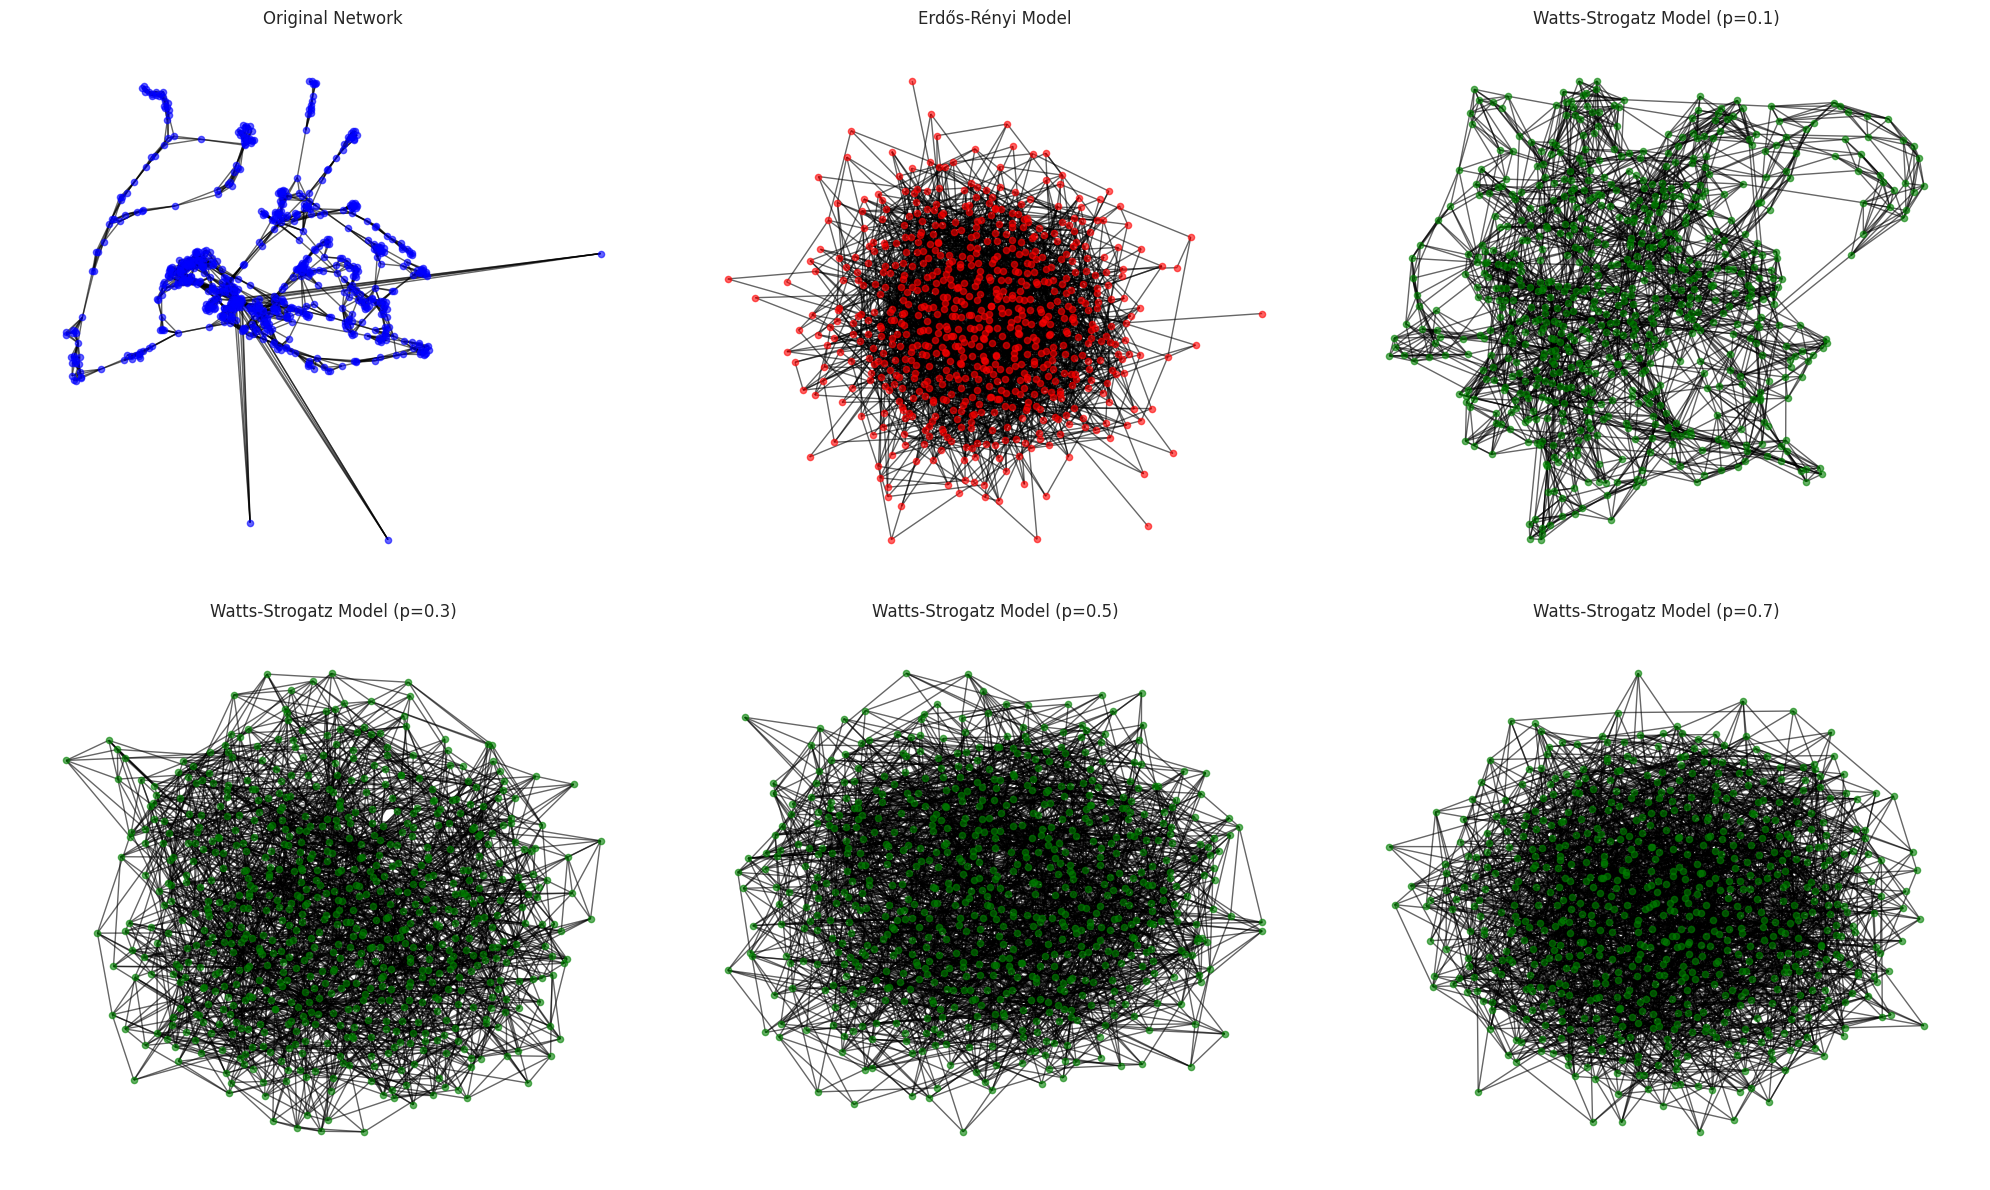

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

pos_original = nx.spring_layout(G_largest)
nx.draw(G_largest, pos_original, ax=axes[0], node_size=20, node_color='blue', alpha=0.6)
axes[0].set_title("Original Network")

pos_er = nx.spring_layout(random_graph)
nx.draw(random_graph, pos_er, ax=axes[1], node_size=20, node_color='red', alpha=0.6)
axes[1].set_title("Erdős-Rényi Model")

for idx, (p, ws_graph) in enumerate(ws_graphs.items()):
    pos_ws = nx.spring_layout(ws_graph)
    nx.draw(ws_graph, pos_ws, ax=axes[idx+2], node_size=20, node_color='green', alpha=0.6)
    axes[idx+2].set_title(f"Watts-Strogatz Model (p={p})")

plt.tight_layout()
plt.show()

# Heavy-Tail Analysis

In [75]:
!pip install powerlaw

Calculating best minimal value for power law fit
Power-law fit summary:
4.812864712360461
Minimum value: 5.0
Maximum likelihood estimation of the scaling parameter (sigma): 0.14578852602255724


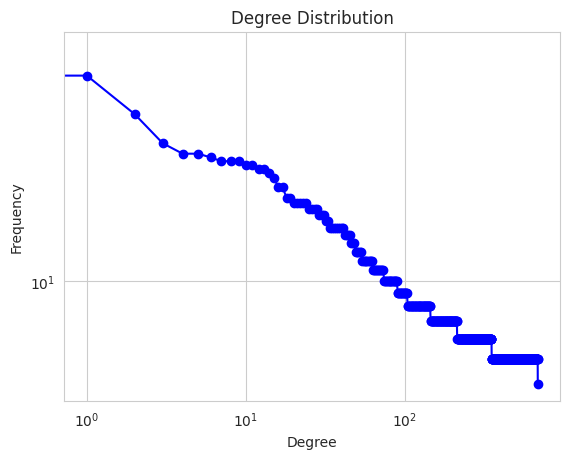

In [76]:
import powerlaw
degrees = dict(G_largest.degree()).values()
degree_sequence = sorted(degrees, reverse=True)
fit = powerlaw.Fit(degree_sequence)
print("Power-law fit summary:")
print(fit.power_law.alpha)
print("Minimum value:", fit.xmin)
print("Maximum likelihood estimation of the scaling parameter (sigma):", fit.sigma)

plt.loglog(degree_sequence, 'b-', marker='o')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# K-Clique Analysis

In [77]:
import random

all_nodes = list(G_largest.nodes())

start_node = random.choice(all_nodes)

sg = nx.dfs_tree(G_largest, start_node, depth_limit=4)
sg = G_largest.subgraph(sg.nodes)

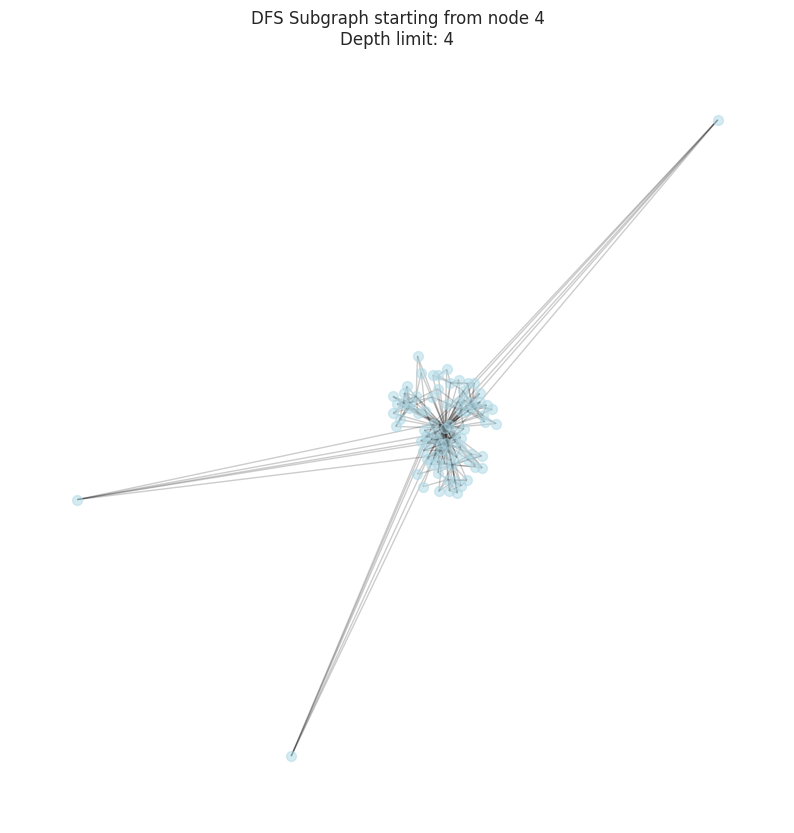

In [81]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(sg)
nx.draw_networkx_nodes(sg, pos, alpha=0.5, node_size=50, node_color='lightblue')
nx.draw_networkx_edges(sg, pos, alpha=0.2)
plt.title(f"DFS Subgraph starting from node {start_node}\nDepth limit: 4")
plt.axis('off')
plt.show()

In [79]:
print(f"Subgraph size: {len(sg)} nodes")
print("K-clique analysis:")
print("----")
for k in range(2, 11):
    try:
        kcliq = list(nx.community.k_clique_communities(sg, k=k))
        num = len(kcliq)
        print(f'Number of {k}-cliques: {num}')
    except:
        print(f'Number of {k}-cliques: 0')

Subgraph size: 83 nodes
K-clique analysis:
----
Number of 2-cliques: 1
Number of 3-cliques: 1
Number of 4-cliques: 3
Number of 5-cliques: 5
Number of 6-cliques: 7
Number of 7-cliques: 0
Number of 8-cliques: 0
Number of 9-cliques: 0
Number of 10-cliques: 0
